In [1]:
import pathlib
import numpy as np
from fytok.Tokamak import Tokamak
from spdm.view import View as sp_view

input_path = pathlib.Path("/home/salmon/workspace/fytok_data/data/15MA inductive - burn")

2023-11-15 14:10:09,762 [   fytok]     INFO: 
#######################################################################################################################
    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU (Institute of Plasma Physics Chinese Academy of Sciences)
            
 url: https://gitee.com/openfusion/fytok_tutorial 
      https://github.com/fusion-yun/fytok_tutorial

 version = develop  (spdm=develop extension=0.2.2.dev11+g706f667, imas_version=v3_38_1_dirty)

 Run by salmon at 2023-11-15T14:10:09.762155.
 Job ID: fytok_salmon_surface_30191

#######################################################################################################################



In [2]:
tokamak = Tokamak(
    f"file+iterprofiles://{next(input_path.glob('*ASTRA.xls')).absolute().as_posix()}",
    f"file+geqdsk://{next(input_path.glob('**/g*.txt')).absolute().as_posix()}",
    device="iter",
    shot=900003,
    time=2.30,
    core_transport={"model": [{"code": {"name": "dummy"}}]},
    core_sources={
        "source": [
            {"code": {"name": "dummy"}},
            # {"code": {"name": "fusion_reaction"}},
        ]
    },
    transport_solver={
        "code": {
            # "name": "fy_trans",
            "parameters": {
                "rho_tor_norm": np.linspace(0.01, 0.995, 128),
                "bvp_rms_mask": [0.96],
                "hyper_diff": 0.0001,
                "max_nodes": 250,
                "equations": {
                    "ion/D/density_thermal": {
                        "profile": 1.5e19,
                        "boundary_condition": [
                            {"identifier": {"index": 2}, "value": [0]},
                            {"identifier": {"index": 1}, "value": [2.0e19]},
                        ],
                    },
                    "ion/T/density_thermal": {
                        "profile": 1.5e19,
                        "boundary_condition": [
                            {"identifier": {"index": 2}, "value": [0]},
                            {"identifier": {"index": 1}, "value": [2.0e19]},
                        ],
                    },
                    "ion/D/temperature": {
                        "profile": 1000,
                        "boundary_condition": [
                            {"identifier": {"index": 2}, "value": [0]},
                            {"identifier": {"index": 1}, "value": [1000]},
                        ],
                    },
                    "ion/T/temperature": {
                        "profile": 1000,
                        "boundary_condition": [
                            {"identifier": {"index": 2}, "value": [0]},
                            {"identifier": {"index": 1}, "value": [1000]},
                        ],
                    },
                    "electrons/temperature": {
                        "profile": 1000,
                        "boundary_condition": [
                            {"identifier": {"index": 2}, "value": [0]},
                            {"identifier": {"index": 1}, "value": [1000]},
                        ],
                    },
                },
            },
        }
    },
)

2023-11-15 14:10:10,054 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.plugins.data.plugin_iterprofiles
2023-11-15 14:10:10,116 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.plugins.data.plugin_geqdsk


In [3]:
tokamak.update_core_profiles()
# boundary_condition={
#     "ion/D/density_thermal": [[0.0], [2.0e19]],
#     "ion/T/density_thermal": [[0.0], [2.0e19]],
#     "ion/D/temperature": [[0.0], [1000]],
#     "ion/T/temperature": [[0.0], [1000]],
#     "electrons/temperature": [[0.0], [1000]],
# },

2023-11-15 14:10:10,573 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.equilibrium.fy_eq
2023-11-15 14:10:10,579 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.core_sources.source.dummy
2023-11-15 14:10:10,586 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.core_transport.model.dummy
2023-11-15 14:10:10,943 [   fytok]    DEBUG: /home/salmon/workspace/fytok/python/fytok/modules/TransportSolverNumerics.py:224:execute: equations={'ion/D/density_thermal': {'profile': 1.5e+19, 'boundary_condition': [{'identifier': {'index': 2}, 'value': [0]}, {'identifier': {'index': 1}, 'value': [2e+19]}]}, 'ion/T/density_thermal': {'profile': 1.5e+19, 'boundary_condition': [{'identifier': {'index': 2}, 'value': [0]}, {'identifier': {'index': 1}, 'value': [2e+

2023-11-15 14:10:10,963 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.view.view_matplotlib
2023-11-15 14:10:11,057 [   fytok]  WARNING: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:403:_plot: plot failed! label=ion/D/density_thermal 1.5e+19 float() argument must be a string or a real number, not 'tags'


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2023-11-15 14:10:11,062 [   fytok]  WARNING: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:403:_plot: plot failed! label=ion/T/density_thermal 1.5e+19 float() argument must be a string or a real number, not 'tags'


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2023-11-15 14:10:11,065 [   fytok]  WARNING: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:403:_plot: plot failed! label=ion/D/temperature 1000.0 float() argument must be a string or a real number, not 'tags'


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2023-11-15 14:10:11,070 [   fytok]  WARNING: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:403:_plot: plot failed! label=ion/T/temperature 1000.0 float() argument must be a string or a real number, not 'tags'


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2023-11-15 14:10:11,075 [   fytok]  WARNING: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:403:_plot: plot failed! label=electrons/temperature 1000.0 float() argument must be a string or a real number, not 'tags'


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


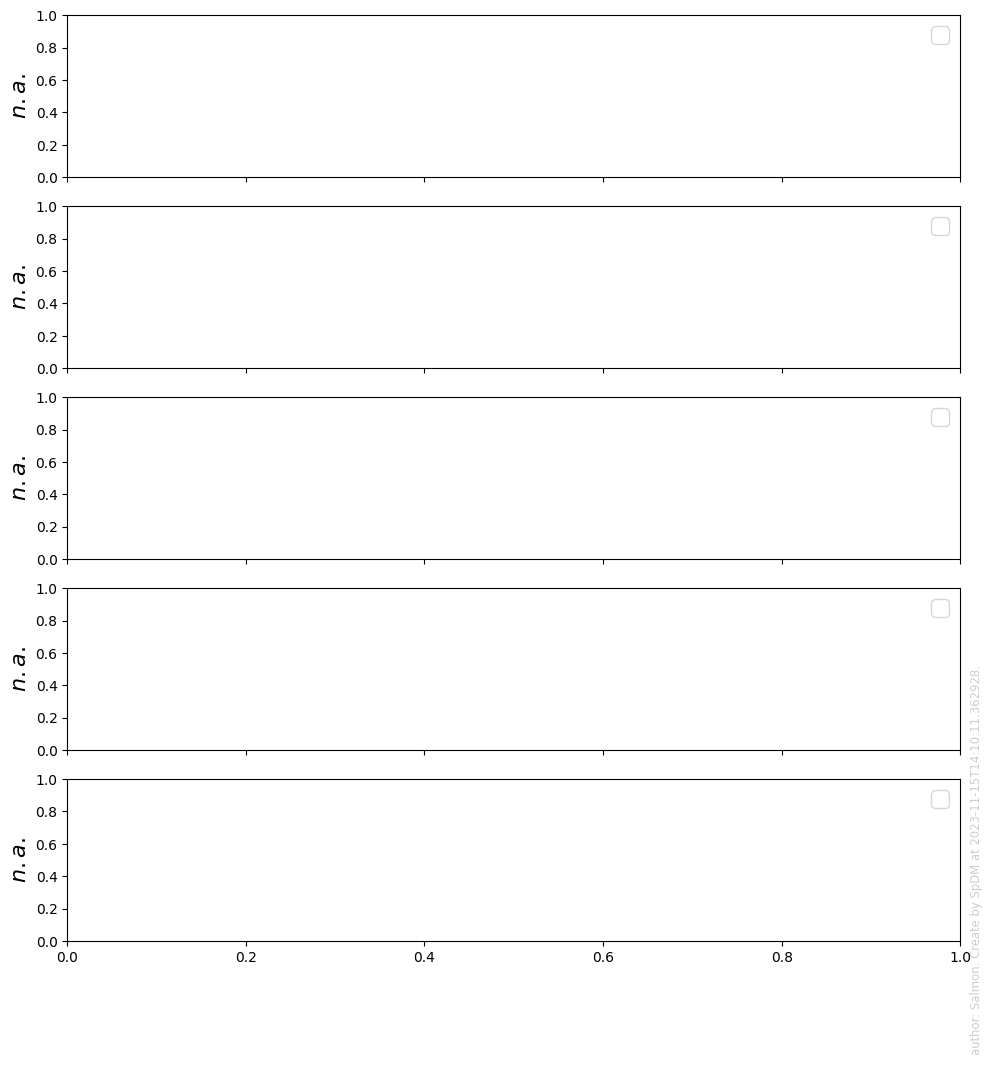

In [4]:
solver_1d = tokamak.transport_solver.time_slice.current.solver_1d
fig = sp_view.plot(
    sum(
        [
            [
                (equ.primary_quantity.profile, equ.primary_quantity.identifier),
                # (equ.primary_quantity.flux, f"{equ.primary_quantity.identifier}_flux"),
                # (equ.primary_quantity.d_dr,f"d({equ.primary_quantity.identifier})/dr"),
                # (equ.primary_quantity.dflux_dr, f"d({equ.primary_quantity.identifier}_flux)/dr"),
            ]
            for equ in solver_1d.equation
        ],
        [],
    ),
    x_axis=solver_1d.grid.rho_tor_norm,
)

In [5]:
core_profiles_1d = tokamak.core_profiles.time_slice.current.profiles_1d

2023-11-15 14:10:12,365 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:327:plot: Plot [index=0] failed! y_label= "None"  [Error when evaluating density_thermal !] 
2023-11-15 14:10:12,367 [   fytok]  WARNING: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:403:_plot: plot failed! label=ion/D/density_thermal 1.5e+19 float() argument must be a string or a real number, not 'tags'


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2023-11-15 14:10:12,371 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:327:plot: Plot [index=1] failed! y_label= "None"  [Error when evaluating density_thermal !] 
2023-11-15 14:10:12,373 [   fytok]  WARNING: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:403:_plot: plot failed! label=ion/T/density_thermal 1.5e+19 float() argument must be a string or a real number, not 'tags'


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2023-11-15 14:10:12,377 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:327:plot: Plot [index=2] failed! y_label= "None"  [Error when evaluating temperature !] 
2023-11-15 14:10:12,380 [   fytok]  WARNING: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:403:_plot: plot failed! label=ion/D/temperature 1000.0 float() argument must be a string or a real number, not 'tags'


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2023-11-15 14:10:12,385 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:327:plot: Plot [index=3] failed! y_label= "None"  [Error when evaluating temperature !] 
2023-11-15 14:10:12,389 [   fytok]  WARNING: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:403:_plot: plot failed! label=ion/T/temperature 1000.0 float() argument must be a string or a real number, not 'tags'


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2023-11-15 14:10:12,393 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:327:plot: Plot [index=4] failed! y_label= "None"  [Error when evaluating temperature !] 
2023-11-15 14:10:12,396 [   fytok]  WARNING: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:403:_plot: plot failed! label=electrons/temperature 1000.0 float() argument must be a string or a real number, not 'tags'


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


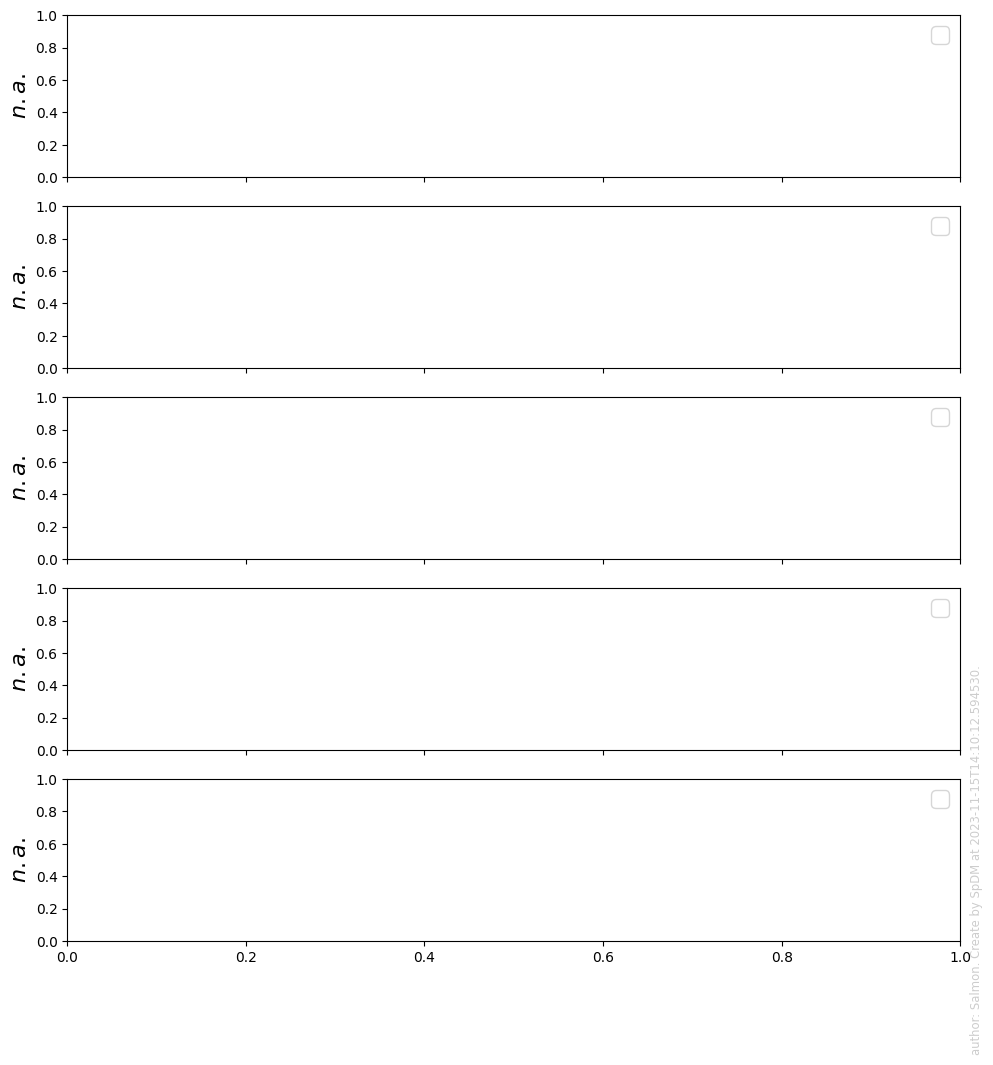

In [6]:
fig = sp_view.plot([
    [
        (core_profiles_1d.get(equ.primary_quantity.identifier), rf"{equ.primary_quantity.identifier} astra"),
        (equ.primary_quantity.profile, rf"{equ.primary_quantity.identifier}")
    ] for equ in solver_1d.equation
],
    x_axis=solver_1d.grid.rho_tor_norm
)

2023-11-15 14:10:13,437 [   fytok]  WARNING: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:403:_plot: plot failed! label=$\chi_e$ nan float() argument must be a string or a real number, not 'tags'


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2023-11-15 14:10:13,441 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:327:plot: Plot [index=1] failed! y_label= "None"  [Error when evaluating \left(\left(2.5 \cdot \chi_e\right) \cdot rho_tor_norm\right) !] 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2023-11-15 14:10:13,445 [   fytok]  WARNING: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:403:_plot: plot failed! label=$D_e$ nan float() argument must be a string or a real number, not 'tags'


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2023-11-15 14:10:13,451 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:327:plot: Plot [index=3] failed! y_label= "None"  [Error when evaluating energy !] 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2023-11-15 14:10:13,456 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:327:plot: Plot [index=4] failed! y_label= "None"  [Error when evaluating energy !] 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


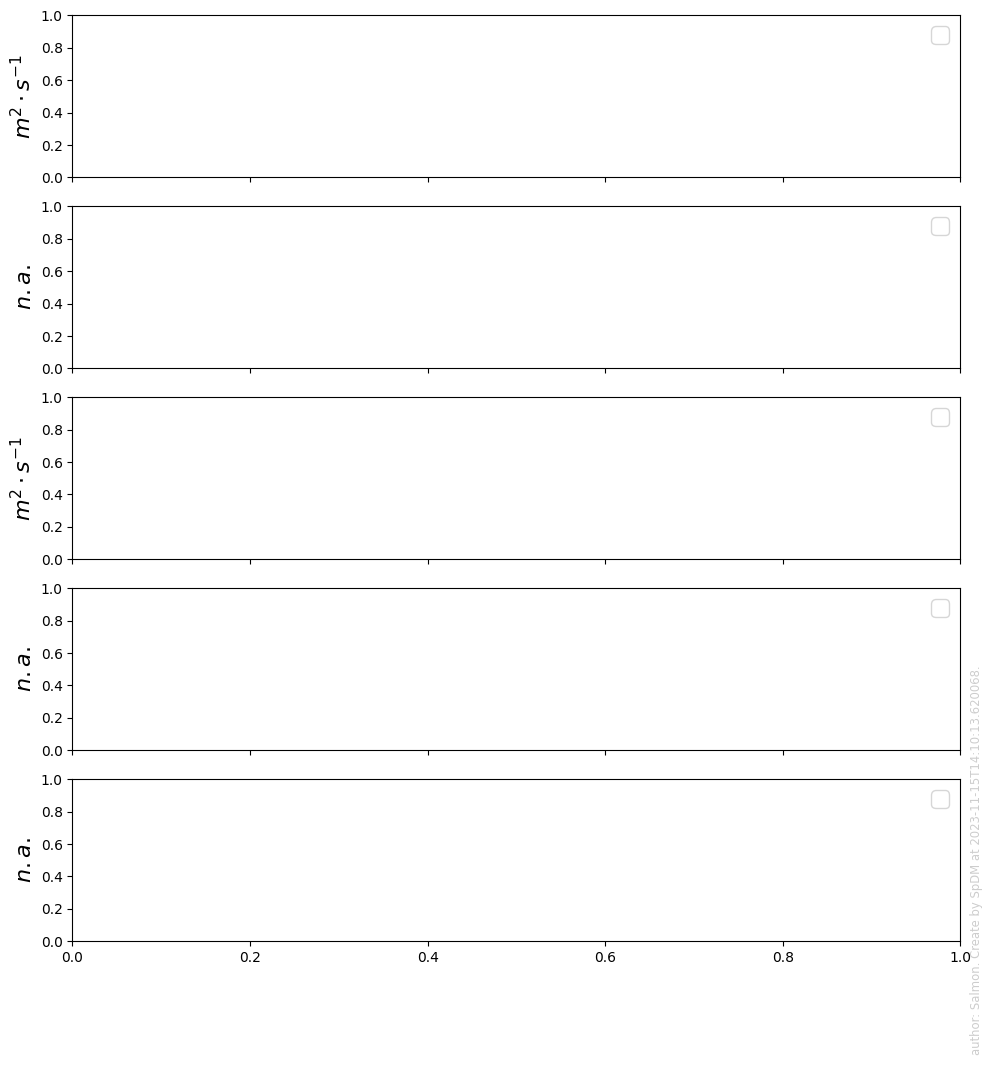

In [7]:
core_sources_1d = tokamak.core_sources.source[0].time_slice.current.profiles_1d
core_transport_1d = tokamak.core_transport.model[0].time_slice.current.profiles_1d

fig = sp_view.plot(
    [
        # (core_sources_1d.electrons.energy, r"$Q_e$"),
        (core_transport_1d.electrons.energy.d, r"$\chi_e$"),
        (core_transport_1d.electrons.energy.v, r"$V^{pinch}_{Te}$"),
        # (core_sources_1d.electrons.energy_decomposed.explicit_part, r"$Q_{e}$ explicit"),
        # (core_sources_1d.electrons.energy_decomposed.implicit_part, r"$Q_{e}$ implicit"),
        (core_transport_1d.electrons.particles.d, r"$D_e$"),
        (core_sources_1d.ion[0].energy, r"$Q_D$"),
        (core_sources_1d.ion[1].energy, r"$Q_T$"),
    ],
    x_axis=solver_1d.grid.rho_tor_norm,
)

In [8]:
equ = solver_1d.equation[1]
a, b, c, d, e, f, g,*_ = equ.coefficient
x = solver_1d.grid.rho_tor_norm
y       = equ.primary_quantity.profile
yp      = equ.primary_quantity.d_dr
flux    = equ.primary_quantity.flux
dflux   = equ.primary_quantity.dflux_dr
fig = sp_view.plot([
    a, b, c, d, e, f, g,
    # [
    #     (d*yp, "$D$"),
    #     (e*y,   "$v$"),
    #     # (flux,   f"$\Gamma$"),
    #     ((c*(f - g * y)).I, r"$S$"),  # $\int c*(f - g \cdot y)$
    #     # ((-d*yp+e*y).I, r"$\Gamma$"),
    #     (-d*yp+e*y-(c*(f - g * y)).I, "residual"),

    # ],
    y, yp

    # [

    #     (dflux, {"label": r"$d\Gamma$"}),
    #     # (Function(flux, x).d(), r"$d\Gamma$"),
    #     ((c*(f - g * y)), r"$c*(f - g \cdot y)$"),
    # ],
],
    x_axis=x)

ValueError: not enough values to unpack (expected at least 7, got 0)